In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt

from fuel.datasets.hdf5 import H5PYDataset

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import mnist

from resnet import identity_block, conv_block

Using TensorFlow backend.


## Variational Autoencoder Parameters

In [2]:
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)

batch_size = int(os.environ.get('BATCH_SIZE', 25))
latent_dim = int(os.environ.get('LATENT_DIM', 256))
intermediate_dim = int(os.environ.get('INTERMEDIATE_DIM', 1024))
epsilon_std = 1.0
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'sigmoid')
dropout = float(os.environ.get('DROPOUT', 0.0))
decay = float(os.environ.get('DECAY', 0.0))
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 3))

## Load CIFAR10 dataset

In [3]:
ftrain = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('train',))
X_train, y_train = ftrain.get_data(ftrain.open(), slice(0, ftrain.num_examples))
X_train = np.moveaxis(X_train[:], 1, 3)
X_train = X_train / 255.

ftest = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('test',))
X_test, y_test = ftest.get_data(ftest.open(), slice(0, ftest.num_examples))
X_test = np.moveaxis(X_test[:], 1, 3)
X_test = X_test / 255.

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# Helper Functions

In [4]:
def create_dense_layers(stage, width):
    dense_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        BatchNormalization(name=bn_name),
        Activation(activation),
        Dropout(dropout),
    ]
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

def sampling(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    z_mean, z_log_var = args
    
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    
    return z_mean + K.exp(z_log_var) * epsilon


def resnet_layers(x, depth, stage_base, transpose=False):
    assert depth in [0, 1, 2, 3]
    
    filters = [64, 64, 256]
    x = conv_block(x, 3, filters, stage=stage_base + 2, block='a', strides=(1, 1), transpose=transpose)
    if depth >= 2:
        x = identity_block(x, 3, filters, stage=stage_base + 2, block='b')
    if depth >= 3:
        x = identity_block(x, 3, filters, stage=stage_base + 2, block='c')
   
    filters = [128, 128, 512]
    x = conv_block(x, 3, filters, stage=stage_base + 3, block='a', transpose=transpose)
    if depth >= 1:
        x = identity_block(x, 3, filters, stage=stage_base + 3, block='b')
    if depth >= 2:
        x = identity_block(x, 3, filters, stage=stage_base + 3, block='c')
    if depth >= 3:
        x = identity_block(x, 3, filters, stage=stage_base + 3, block='d')
    
    filters = [256, 256, 1024]
    x = conv_block(x, 3, filters, stage=stage_base + 4, block='a', transpose=transpose)
    if depth >= 1:
        x = identity_block(x, 3, filters, stage=stage_base + 4, block='b')
    if depth >= 2:
        x = identity_block(x, 3, filters, stage=stage_base + 4, block='c')
        x = identity_block(x, 3, filters, stage=stage_base + 4, block='d')
    if depth >= 3:
        x = identity_block(x, 3, filters, stage=stage_base + 4, block='e')
        x = identity_block(x, 3, filters, stage=stage_base + 4, block='f')
   
    filters =  [512, 512, 2048]
    x = conv_block(x, 3, filters, stage=stage_base + 5, block='a', transpose=transpose)
    if depth >= 2:
        x = identity_block(x, 3, filters, stage=stage_base + 5, block='b')
    if depth >= 3:
        x = identity_block(x, 3, filters, stage=stage_base + 5, block='c')
    
    return x

## Loss Function

In [5]:
def kl_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logx_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * img_chns * metrics.binary_crossentropy(x, x_decoded_mean)
    return xent_loss

def vae_loss(x, x_decoded_mean):
    return logx_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

# VAE

In [6]:
def make_encoder():
    encoder_input = Input(batch_shape=(batch_size,) + original_img_size)
    resnet = resnet_layers(encoder_input, depth=resnet_depth, stage_base=0)
    encoder_layers = [
        create_dense_layers(stage=9, width=intermediate_dim),
        Flatten(),
    ]
    enc_dense = inst_layers(encoder_layers, resnet)
    
    z_mean = Dense(latent_dim, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(enc_dense)
    z_log_var = Dense(latent_dim, kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(enc_dense)
    
    return Model(inputs=encoder_input, outputs=[z_mean, z_log_var])

def make_decoder():
    decoder_input = Input(batch_shape=(batch_size,) + (latent_dim,))
    decoder_layers = [
        create_dense_layers(stage=10, width=intermediate_dim),
        Reshape((4, 4, intermediate_dim // 16)),
    ]
    dec_out = inst_layers(decoder_layers, decoder_input)
    
    dec_out = resnet_layers(dec_out, depth=resnet_depth, transpose=True, stage_base=10)
    decoder_out = Conv2DTranspose(name='x_decoded', filters=3, kernel_size=1, strides=1, activation='sigmoid')(dec_out)
    
    return Model(inputs=decoder_input, outputs=decoder_out)

In [7]:
encoder = make_encoder()
decoder = make_decoder()

encoder.summary()
decoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (25, 32, 32, 3)       0                                            
____________________________________________________________________________________________________
res2a_branch2a (Conv2D)          (25, 32, 32, 64)      256         input_1[0][0]                    
____________________________________________________________________________________________________
bn2a_branch2a (BatchNormalizatio (25, 32, 32, 64)      256         res2a_branch2a[0][0]             
____________________________________________________________________________________________________
activation_1 (Activation)        (25, 32, 32, 64)      0           bn2a_branch2a[0][0]              
___________________________________________________________________________________________

In [8]:
# VAE
x_input = Input(batch_shape=(batch_size,) + original_img_size)
z_mean, z_log_var = encoder(x_input)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
_output = decoder(z)

vae = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
vae.compile(optimizer=optimizer, loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (25, 32, 32, 3)       0                                            
____________________________________________________________________________________________________
model_1 (Model)                  [(25, 256), (25, 256) 18507072    input_3[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (25, 256)             0           model_1[1][0]                    
                                                                   model_1[1][1]                    
____________________________________________________________________________________________________
model_2 (Model)                  (25, 32, 32, 3)       8308611     lambda_1[0][0]          

In [9]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=50)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, min_lr=0.001 * learning_rate)
callbacks=[early_stopping, reduce_lr]
if 'CMDLINE' not in os.environ:
    callbacks += [TQDMNotebookCallback()]

history = vae.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, X_test),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

Elapsed:  285358.49025678635


,loss,lr,val_loss
count,3.840000e+02,384.000000,384.000000
mean,4.864193e+04,0.000436,2062.675204
std,8.599728e+05,0.000400,1252.834880
min,1.790436e+03,0.000016,1794.688167
0%,1.790436e+03,0.000016,1794.688167
25%,1.791175e+03,0.000063,1795.410360
50%,1.793584e+03,0.000250,1798.556873
75%,1.802264e+03,0.001000,1808.360118
95%,3.172985e+03,0.001000,2921.968339
99%,9.976952e+03,0.001000,8887.012139


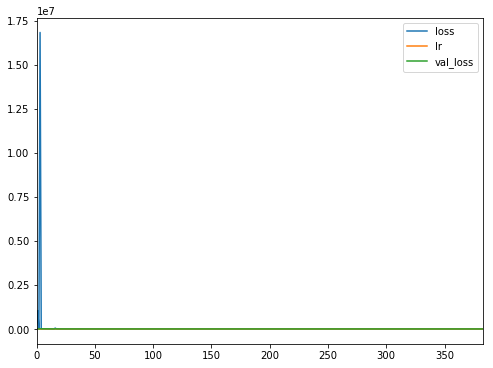

In [10]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

In [11]:
# Eval kl loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=kl_loss)
val_kl_loss = m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

# Eval logx loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logx_loss)
val_logx_loss = m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

print()
print("kl_loss = %.2f" % val_kl_loss)
print("logx_loss = %.2f" % val_logx_loss)

10000/10000 [==============================] - 53s    

kl_loss = 32.79
logx_loss = 1763.28


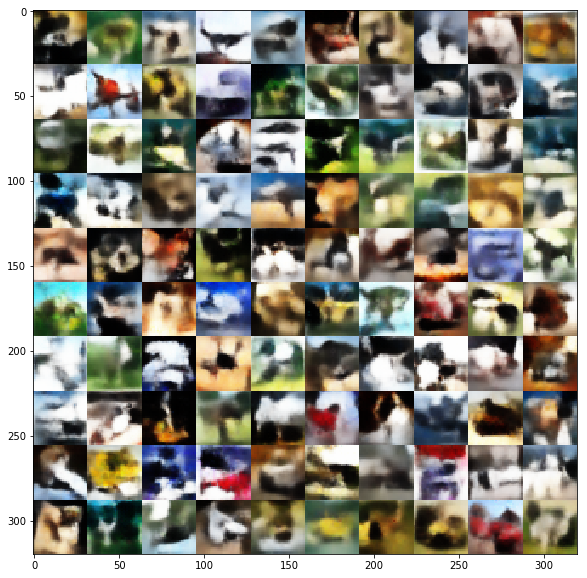

In [12]:
import matplotlib.pyplot as plt
n = 10
figure = np.zeros((img_rows * n, img_cols * n, img_chns))

batches = (n * n + batch_size - 1) // batch_size
digits = []
for i in range(batches):
    z_sample = np.random.normal(size=[batch_size, latent_dim]).reshape(batch_size, latent_dim)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digits += [x_decoded[i].reshape(img_rows, img_cols, img_chns) for i in range(batch_size)]

for j in range(n):
    for i in range(n):
        digit = digits[j * n + i]
        d_x = i * img_rows
        d_y = j * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [13]:
if os.environ.get('OUTDIR', None):
    encoder.save(os.path.join(os.environ['OUTDIR'], 'encoder-depth-' + str(resnet_depth) + '.h5'))
    decoder.save(os.path.join(os.environ['OUTDIR'], 'decoder-depth-' + str(resnet_depth) + '.h5'))

    vals = {k: v for k, v in locals().items() if type(v) in [int, float, bool]}
    with open(os.path.join(os.environ['OUTDIR'], 'params-depth-' + str(resnet_depth) + '.json'), 'w') as f:
        json.dump(vals, f)